# Predicting Optimal Fertilizers

Kaggle hosts monthly Playground Series competitions. These competitions use datasets generated by deep learning models, based on real-world data. For more details, please visit the competition's [website](https://www.kaggle.com/competitions/playground-series-s5e6/overview).

The goal of this competition is to develop a model that recommends the optimal fertilizer based on soil and environmental data, including temperature, humidity, soil type, and crop type. In essence, this is a **classification** problem. The evaluation metric for this competition is the Mean Average Precision at 3 (MAP@3). Our model will recommend up to 3 fertilizer per row, ranked by preference from left to right. This means a correct prediction in the first position scores higher than one in the second or third position. For example, if our model recommends three fertilizers for a given instance, and the submission is:

`id, Fertilizer Name`

`1, A B C`

The scoring works as follows:

- If the optimal fertilizer is A, the score is 1.
- If the optimal fertilizer is B, the score is 0.5.
- If the optimal fertilizer is C, the score is 0.33.
- If none of the model's recommendations are correct, the score for that instance is 0.

The final score for the model is the average of these scores across all test samples, resulting in a value between 0 and 1.

Now, let's take a closer look at the dataset!

In [3]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Project root added to path: {project_root}")

#plot in a separate window
# %matplotlib qt 
#plot below the cell
%matplotlib inline 

Project root added to path: c:\Users\Mauricio\Desktop\Kaggle-datasets\Predicting-Optimal-Fertilizers


In [4]:
# plotting libraries
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# My plot functions
import src.plotting as sp
import src.preprocessing_data as prd
import src.feature_engineering as fte

# magic command for my changes in functions
# %autoreload 2
# # To reload it, use:
%reload_ext autoreload

In [5]:
#Loading data
pof_df = pd.read_csv('../data/train.csv')
pof_df_test = pd.read_csv('../data/test.csv')

pof_df.rename(columns={'Temparature': 'Temperature'}, inplace=True)
pof_df_test.rename(columns={'Temparature': 'Temperature'}, inplace=True)

# Exploratory Data Analysis

The first step is to perform an exploratory data analysis (EDA) on the dataset. This will help us understand the relationships between the features and the target variable (Fertilizer Name). Through EDA, we can gain insights into which features are most influential for fertilizer recommendation, identify opportunities to create new informative features, check for data quality issues, and make informed decisions about data preprocessing and model selection.

# 1. Initial Data Overview

To begin, let's familiarize ourselves with the dataset's structure and content. We will:

- **Inspect Data Types**: Identify whether each feature is numerical, categorical, or binary.
- **Examine Unique Values**: Count the number of unique values for each feature to understand its cardinality, especially for categorical variables.
- **Check for Missing Values**: Quantify any missing data in each column, as this will need to be addressed.
- **Review Basic Statistics**:
    - For **numerical features**, calculate descriptive statistics like mean, median, standard deviation, minimum, and maximum values. This helps understand the central tendency, spread, and range of the data.
    - For **categorical features**, identify the most frequent values and their counts.
- **Analyze Target Variable Distribution**: Since this is a classification problem, understanding the distribution of the target variable (Fertilizer Name) is crucial. We'll check for class imbalances, which might affect model training and evaluation.
- **Preview the Data**: Display the first few rows to get a qualitative sense of the data.

In [50]:
pof_df.head()

,id,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [6]:
if 'id' in list(pof_df.columns):
    pof_df = pof_df.drop('id', axis=1)
col_list = list(pof_df.columns)

In [52]:
pof_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temperature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-null  int64 
 3   Soil Type        750000 non-null  object
 4   Crop Type        750000 non-null  object
 5   Nitrogen         750000 non-null  int64 
 6   Potassium        750000 non-null  int64 
 7   Phosphorous      750000 non-null  int64 
 8   Fertilizer Name  750000 non-null  object
dtypes: int64(6), object(3)
memory usage: 51.5+ MB


There's no missing values! That's nice, we don't need to worry about imputations. Most of the features are numerical, except for `Soil Type` and `Crop Type`, beyond the target variable `Fertilizer Name`. There's a mistype in one column name that I'll correct because it's annoying me.

In [53]:
pof_df.describe()

,Temperature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [54]:
pof_df.nunique()

Temperature        14
Humidity           23
Moisture           41
Soil Type           5
Crop Type          11
Nitrogen           39
Potassium          20
Phosphorous        43
Fertilizer Name     7
dtype: int64

That's an interesting observation: many features have a surprisingly small number of unique values. This is an important finding, as it suggests we might benefit from treating some of these columns as categorical (or discrete numerical) features for our analysis and preprocessing, even if their data type is currently numeric. This approach can often reveal patterns more clearly than treating them as continuous variables, especially when the distinct values represent specific groups or ranges.

## 2. Visualizing Feature Distributions and Relationships

To gain further insights and inform our subsequent steps, we will now visualize the data. Given the low cardinality of many features, bar charts (or count plots) are excellent for understanding their individual distributions. We will also explore how these features relate to our target variable, `Fertilizer Name`, to identify potential predictive patterns.

Specifically, we will:
*   **Plot the distribution of each feature:** This will show us the frequency of each unique value.
*   **Plot the distribution of the target variable (`Fertilizer Name`):** This is crucial for checking class balance.
*   **Visualize the relationship between each feature and the target variable:** For example, we can use grouped or stacked bar charts to see how the distribution of `Fertilizer Name` changes across different values of a feature (e.g., `Soil Type` or `Temperature` bands).


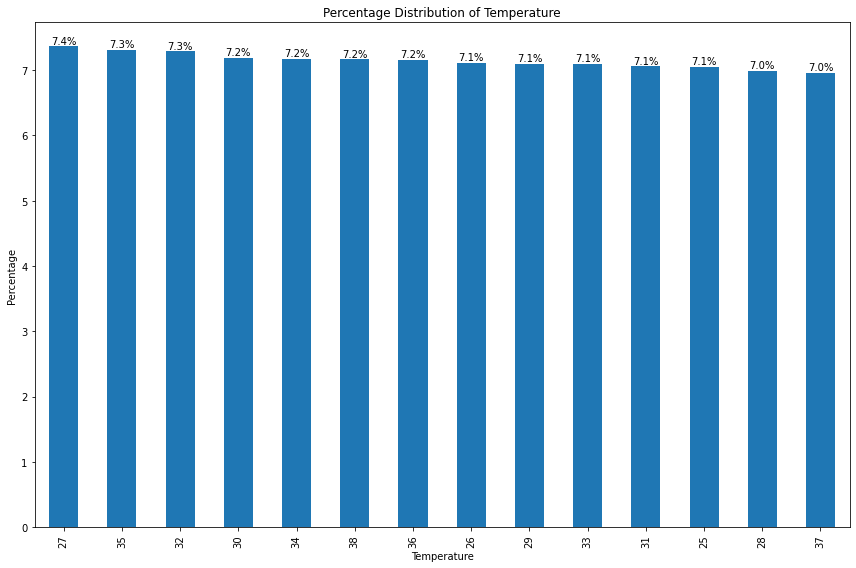

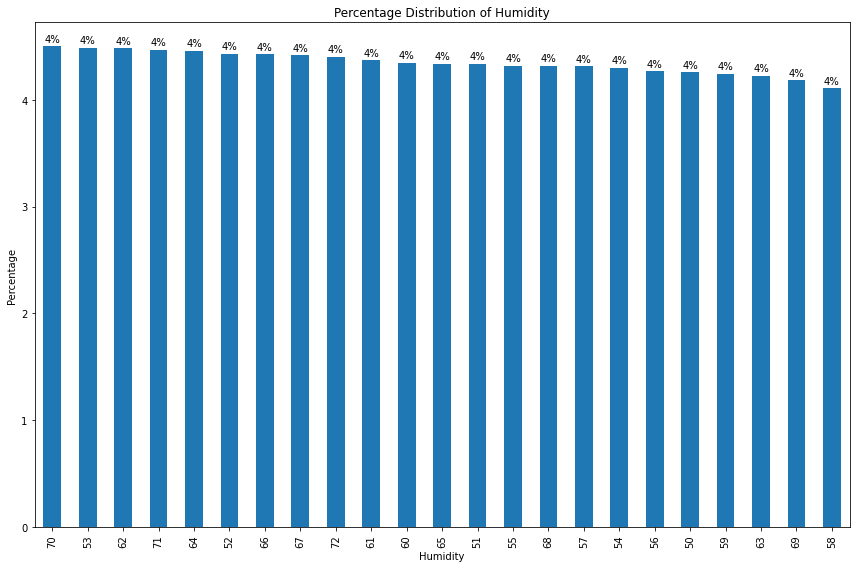

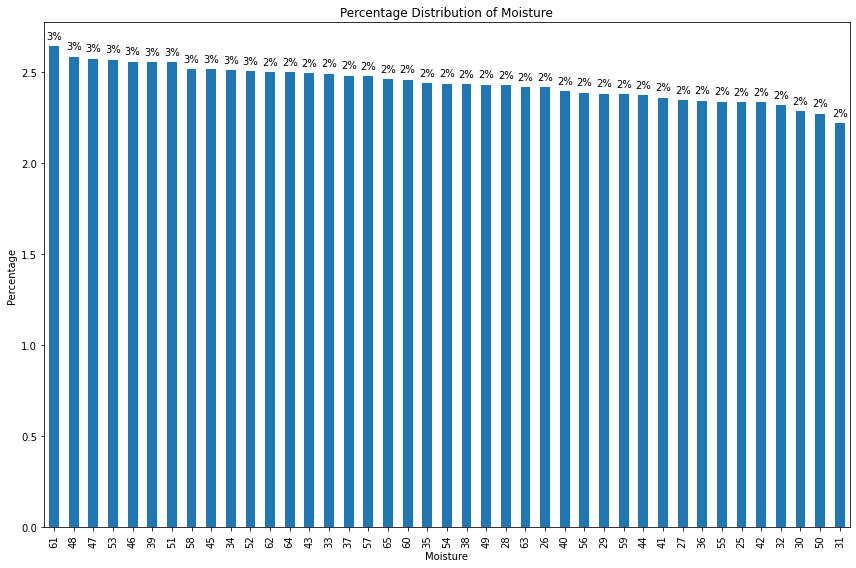

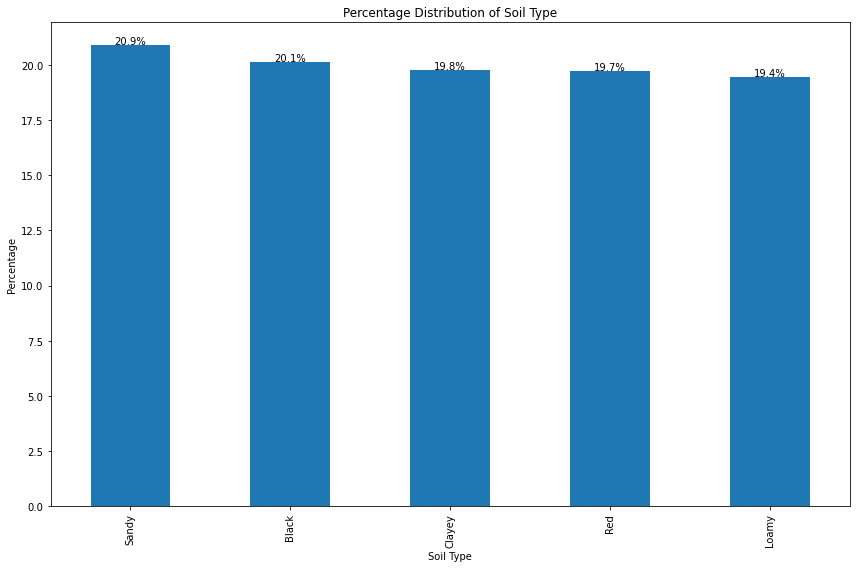

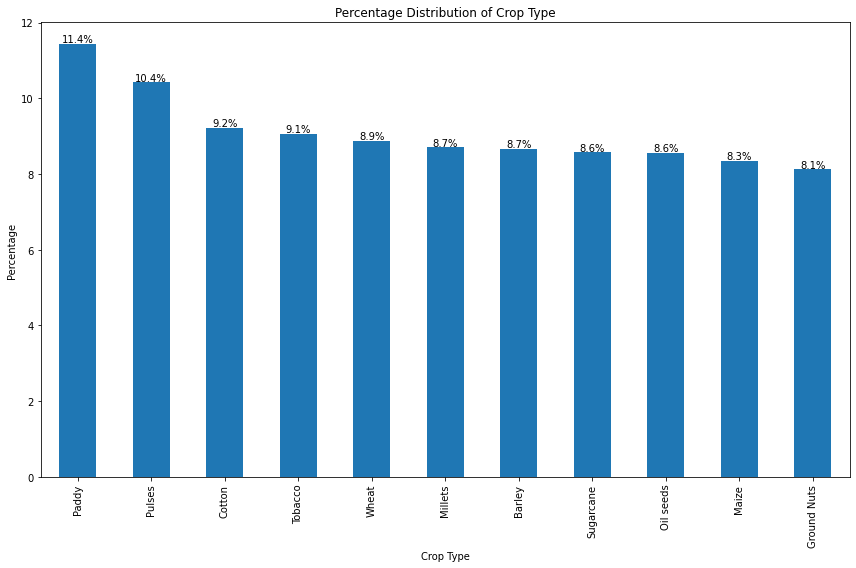

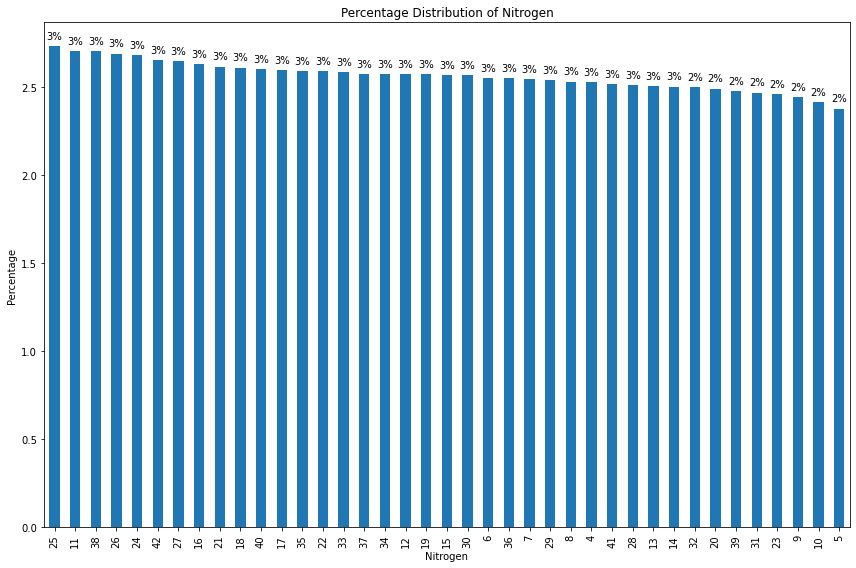

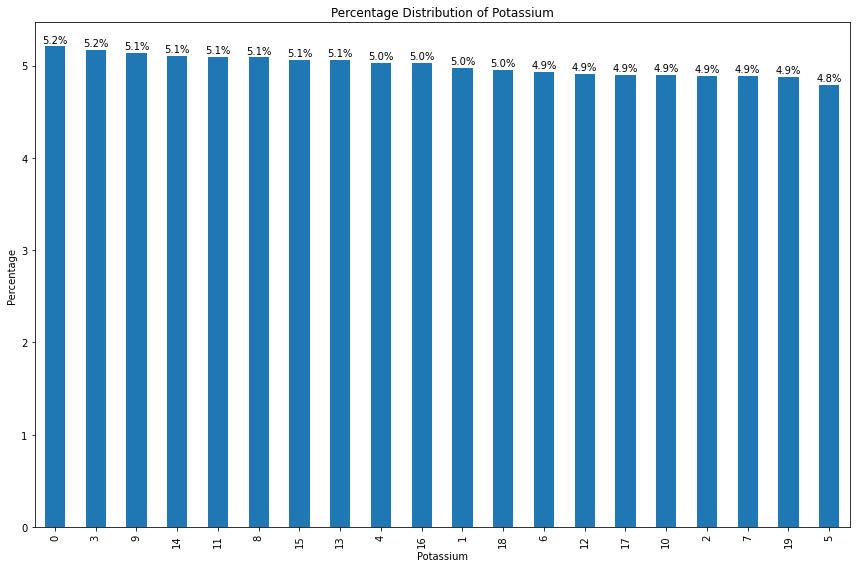

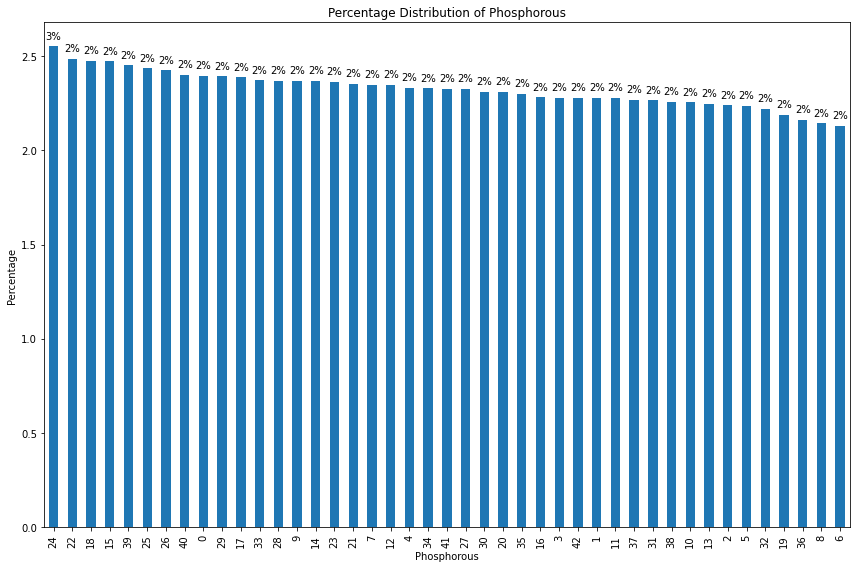

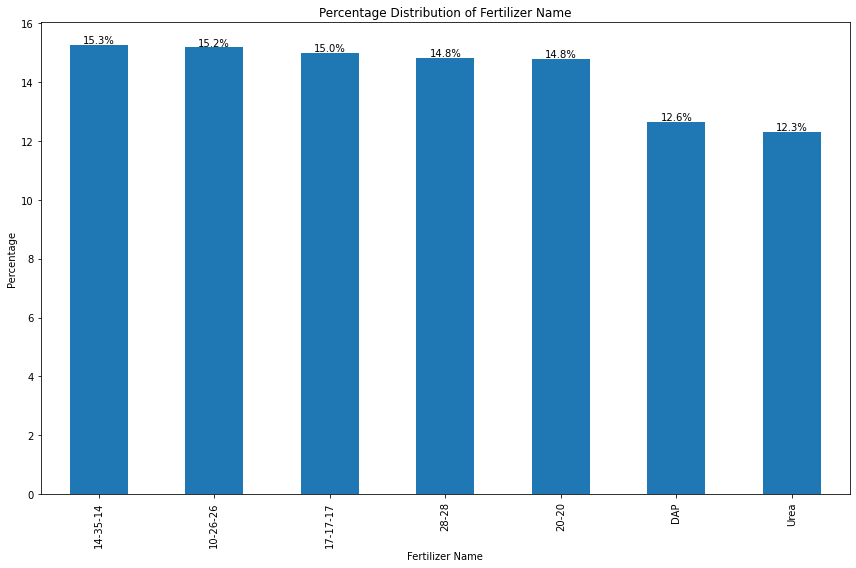

In [55]:
sp.plot_pct_dist(pof_df, col_list)

These bar plots show that almost all features (and the target variable) are well-distributed. For the features, the only value I noticed that isn't well-distributed is crop type: nine types each represent 8% - 9% of the data, and two types represent more than 10% (though I don't think this is a significant issue). DAP and Urea each constitute around 12% of the target variable, while the others are around 15% (again, not a significant concern regarding the need for resampling).

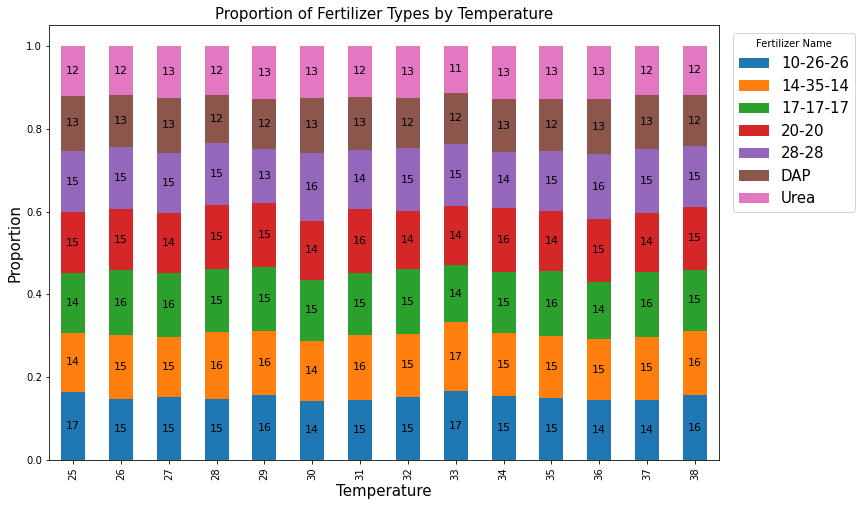

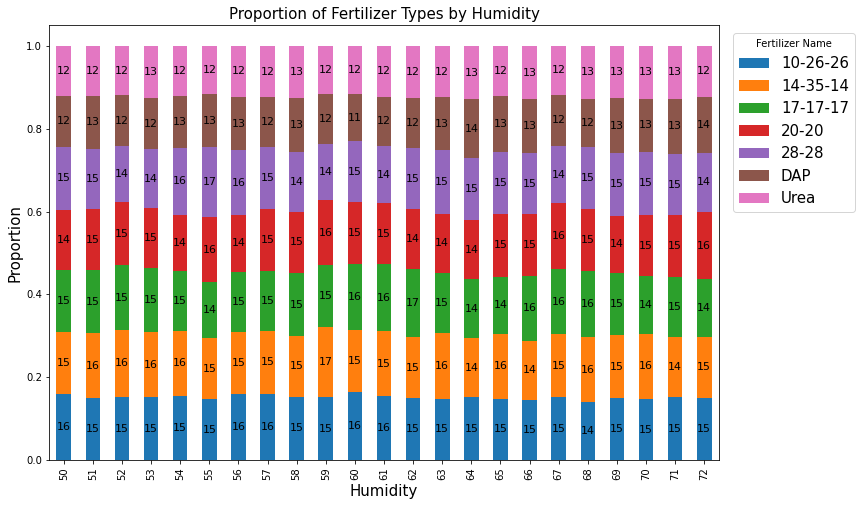

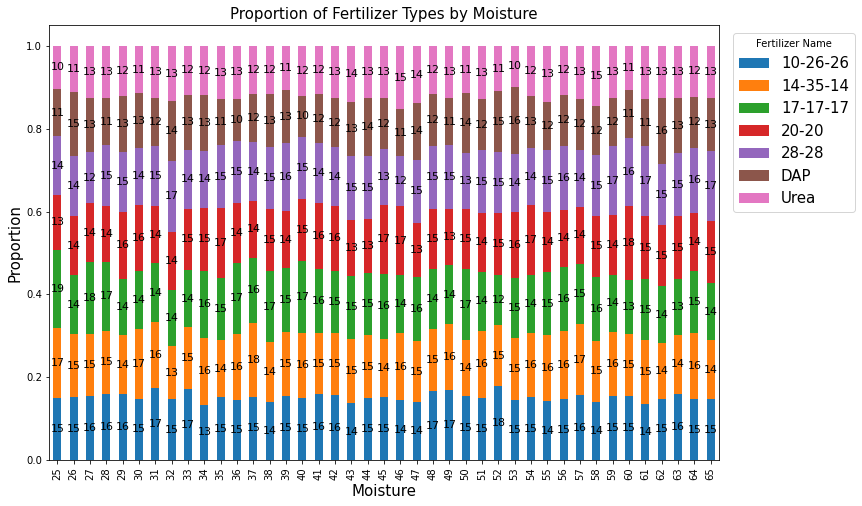

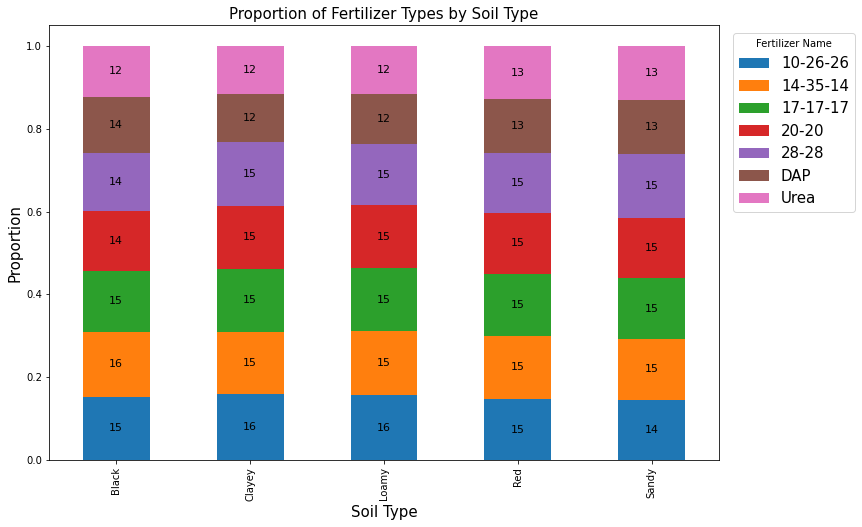

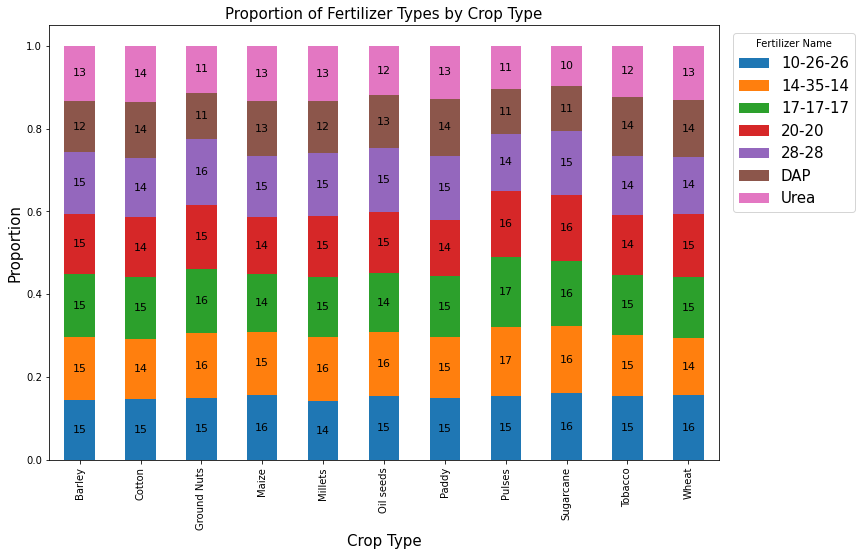

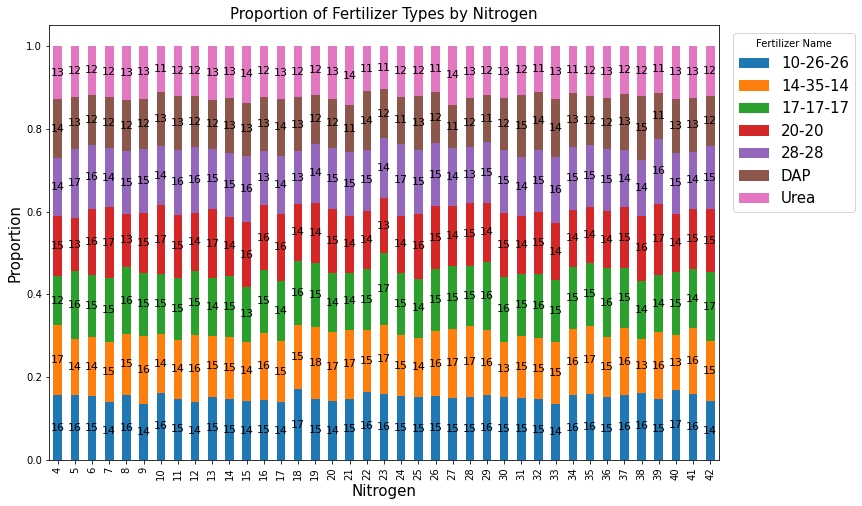

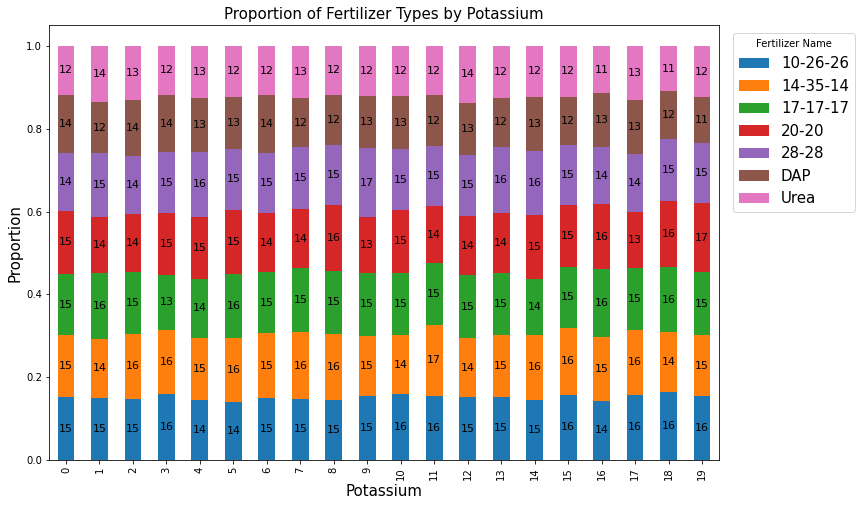

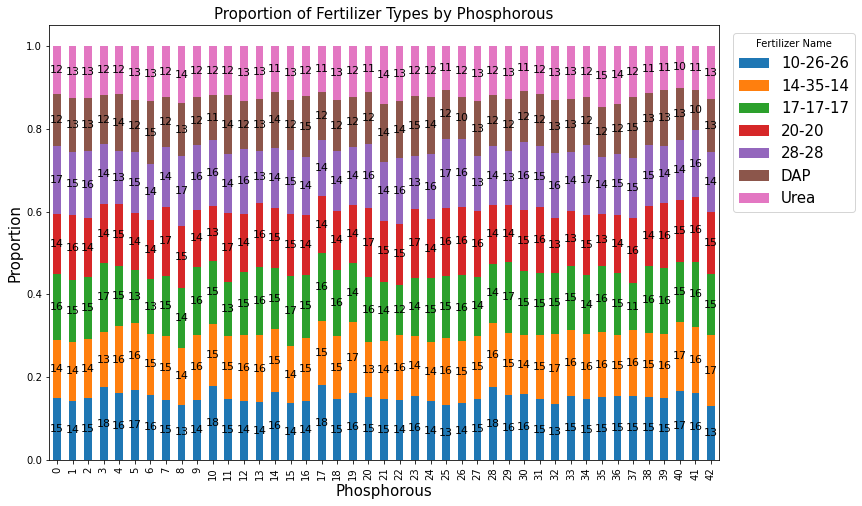

In [56]:
sp.plot_bar_chart(pof_df, col_list, 'Fertilizer Name', stacked= True)

The stacked bar plots visualize the relationship between each feature and the target variable, `Fertilizer Name`. At first glance, the fertilizer proportions appear relatively consistent across the different values of each feature, making strong patterns difficult to discern visually. However, closer inspection reveals subtle but potentially significant variations, suggesting that predictive relationships do exist. It's kind boring to look at those charts, and also can lead to errors. But something came to my mind while looking at them: heatmaps! These charts reminded me of matrices (I worked a lot with matlab during my master). But how would I build these heatmaps? By working with probabilities! Let me explain.

Let's use a real example from our charts. The overall probability of recommending the fertilizer `14-35-14`  is its proportion in the sample, which is **15.2%**. However, for `Temperature = 33°C`,its proportion jumps to **17%**! So, it's clearly more likely to be recommended at this temperature. But how much more likely? I searched for two metrics to quantify this: **Percent Lift** and **Log-Transformed Lift**.

### Percent lift

The general probability for the dataset to recommend a fertilizer `A` is `P(A)`, and to recommend the same fertilizer given a condition `B` is P(A|B). If the condition does not affect the recommendation we expect that `P(A) = P(A|B)`. But if it does, we can calculate the relative change using the formula:

\begin{equation*}
P_{lift} = \frac{P(A|B)-P(A)}{P(A)}
\end{equation*}

In the example above for the fertilizer `14-35-14` the probabilities and the percent lift would be:

\begin{align*}
&P(A) = \text{15.3\%} \\ 
&P(A|B) = \text{17\%} \\
&P_{lift} \approx \frac{0.17 - 0.153}{0.153} = 0.11 = \text{11\%}
\end{align*}

This means that the lift is **11%**, what means that for `temperature = 33°C` the fertilizer `14-35-14` is **11% more likely** to be recommended than its overall average. 

### Log-transformed lift

The log-transformed lift is, as the name suggests, the logarithm of the ratio between `P(A|B)` and `P(A)`. The main goal is to make the resulting scale symmetric. The formula is:

\begin{equation*}
P_{log} = \log{\left(\frac{P(A|B)}{P(A)}\right)}
\end{equation*}

This transformation is valuable because it centers the "no effect" point at 0. A positive value indicates a positive association (over-representation), while a negative value indicates a negative one (under-representation). Most importantly, the scale is symmetric: an event being twice as likely (`ratio=2`) or half as likely (`ratio=0.5`) results in log-ratios of **log(2)** and **log(0.5)**, which are **equidistant from zero**. This is ideal for both visualization with diverging color palettes and for use as a feature in some machine learning models.

For our `14-35-14` example:

\begin{equation*}
P_{log} = \log{\left(\frac{0.17}{0.153}\right)} \approx \log{(1.11)} = 0.10 = \text{10\%}
\end{equation*}

Since the value is positive, it confirms the positive association.

The path forward is clear: let's create heatmaps using the log-transformed lift to visualize these relationships.

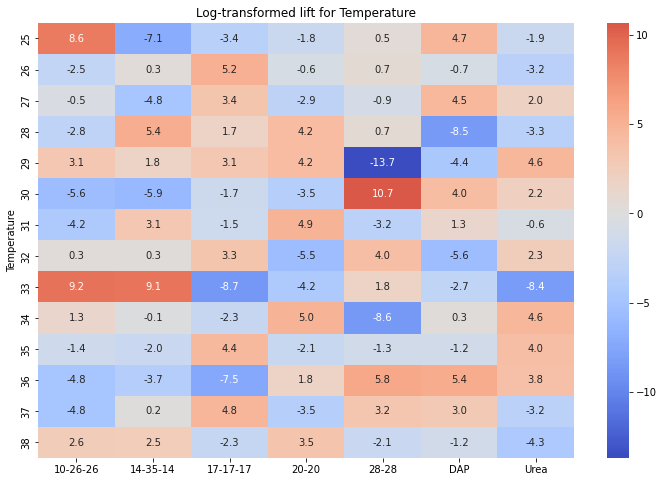

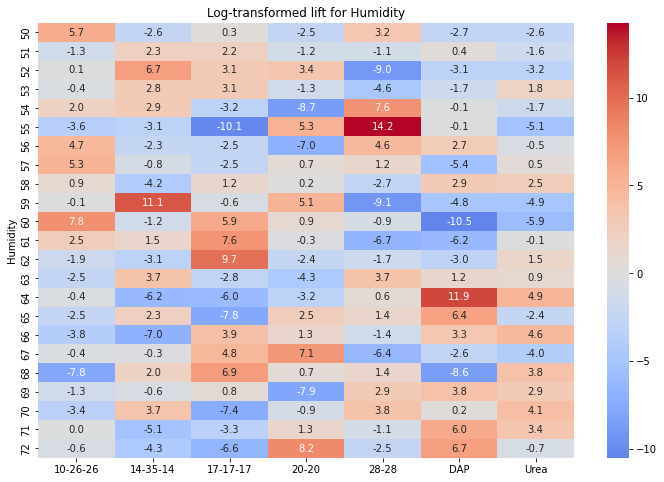

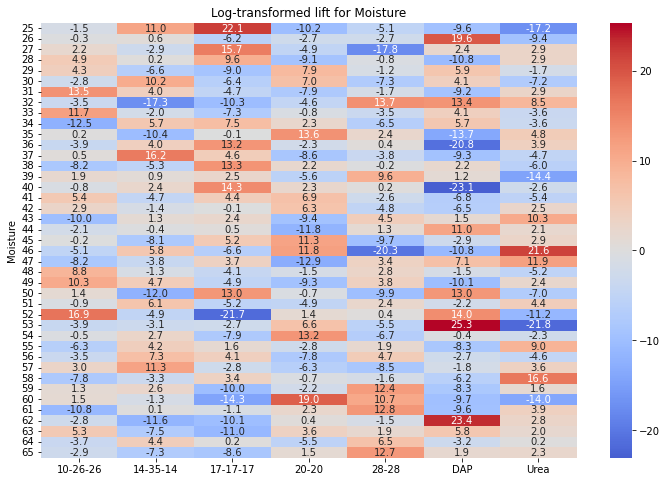

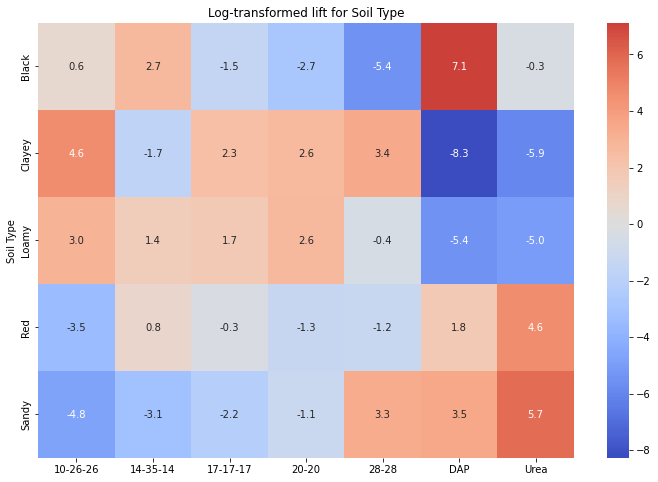

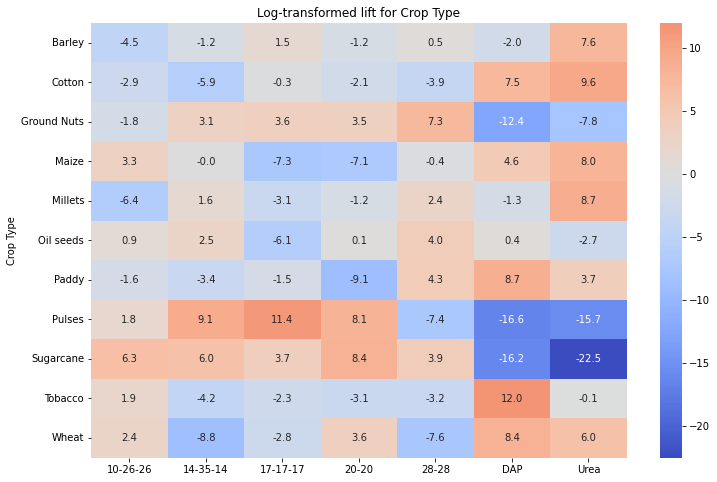

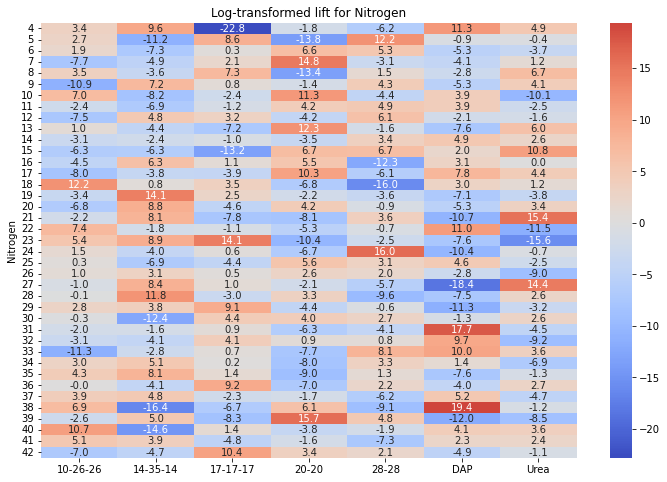

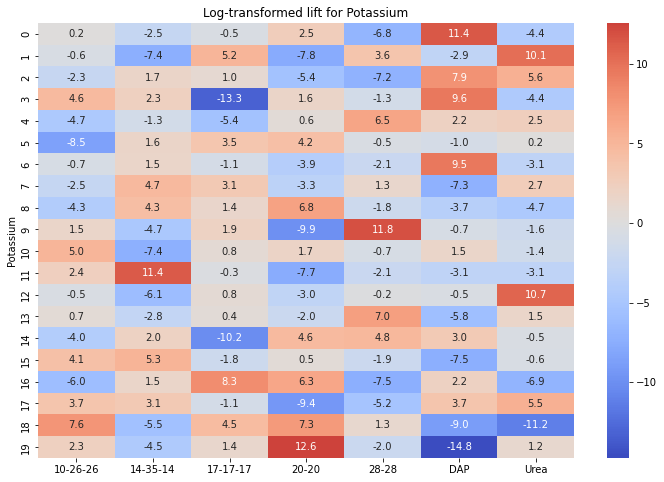

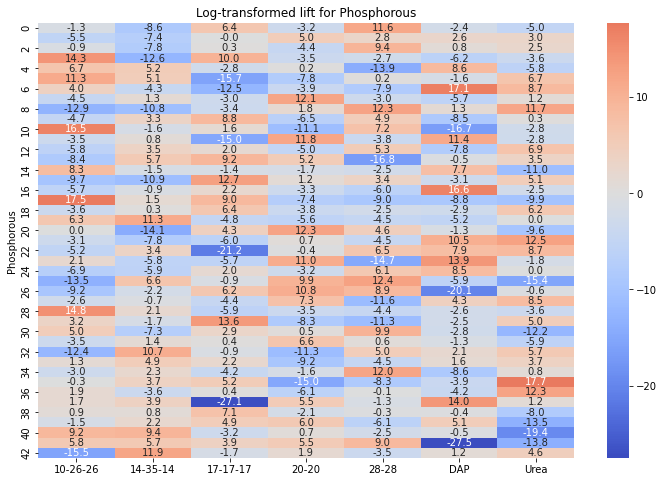

In [57]:
sp.plot_Plift_heatmap(pof_df, col_list, 'Fertilizer Name', Plog=True)

Excellent. This method allows us to effectively visualize the association between feature values and fertilizer recommendations. On the generated heatmaps, color intensity represents the strength of this association, where blue signifies a negative lift and red indicates a positive lift.

I built these charts to better visualize the frequencies, but why do I need to better visualize this? I'll try to see more than 1 feature where are blue or red values, and see if the combination of 2 features tell us something. The goal here is to create new features and see if they improve the models performance. 

### 3. Feature Engineering

Based on insights from the initial EDA and the performance of the baseline models, a feature engineering strategy was developed to create more informative predictors. The baseline models relied heavily on absolute nutrient values but struggled to differentiate between similar fertilizers. The goal of these new features is to provide the model with more direct signals about the *relationships* and *balances* between the raw inputs.

The primary strategies included:

* **Nutrient Ratios and Proportions:** To better capture the chemical balance of the soil, features representing nutrient ratios (e.g., `N/P`, `P/K`), total nutrient load (`npk_sum`), and the proportion of each nutrient were created. This directly addresses the model's confusion between fertilizers with different N-P-K compositions.

* **Effective Nutrient Availability:** In agriculture, the absolute amount of a nutrient is less important than the amount that is *biologically available* for a plant to absorb. Soil moisture is the primary vehicle for transporting these dissolved nutrients to the roots. To model this critical physical relationship, three new interaction features were engineered to act as a proxy for effective nutrient availability:
    1. `moisture_x_nitrogen`
    2. `moisture_x_phosphorous`
    3. `moisture_x_potassium`
    
    A high value in these new features indicates a state where a key nutrient is not only present but also likely in a form that is readily usable by the crop.

* **Group-Based Features ($\Delta$ Nutrient):** A key factor in recommending a fertilizer is understanding the soil's current nutrient status compared to its typical state. Is there a deficit that needs correcting, or a surplus that should be left alone?

    To quantify this "nutrient need," we can calculate the average nutrient level for each `Soil Type`. This group average represents the **expected baseline** for that soil. By comparing a specific sample's nutrient level to its group's average, we can create a powerful new feature that represents the **$\Delta$ nutrient** (surplus or deficit).

    For example, a large negative value for a `nitrogen_delta` feature would be a very strong signal to the model that a nitrogen-rich fertilizer is required. This is a much richer feature than the absolute nitrogen value alone, as it is tailored to the context of the soil it's in.

In [61]:
pof_df = fte.delta_nutrient(pof_df)
pof_df = fte.moisture_nutrient(pof_df)
pof_df = fte.nutrients_ratio(pof_df)

pof_df_test = fte.delta_nutrient(pof_df_test)
pof_df_test = fte.moisture_nutrient(pof_df_test)
pof_df_test = fte.nutrients_ratio(pof_df_test)

## 4. Data preprocessing

The final step before training our models is to preprocess the data into a suitable numerical format. This process will handle our categorical and numerical features differently to ensure compatibility with a wide range of machine learning algorithms.

- **Categorical Features** (`Soil Type`, `Crop Type`): These will be transformed using one-hot encoding. This prevents the model from assuming a false ordinal relationship between the categories.
- **Numerical Features** (all others): These will be scaled using a `StandardScaler`. This standardization is essential for linear and distance-based models to perform optimally. While not strictly necessary for tree-based algorithms like XGBoost, applying this step creates a universal pipeline, ensuring our preprocessed data is ready for any model we might test in future experiments, such as ensembling.

These transformations will be implemented using Scikit-learn's `ColumnTransformer` to create a clean, single, and reproducible preprocessing pipeline.

In [ ]:
# This code only works if there's a folder called 'data' inside the root folder
prd.preprocess(pof_df, pof_df_test, 'Fertilizer Name', 'pof')